# Простейшая рекуррентная сеть
В этом ноутбуке мы пройдемся по основам работы с RNN. Сегодня займемся задачей генерации текста. 

In [1]:
import warnings
from typing import Iterable, Tuple
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.distributions.categorical import Categorical
import tqdm

warnings.filterwarnings("ignore")

В качестве обучающего датасета возьмем набор из 120 тысяч анекдотов на русском языке. 
[Ссылка на данные](https://archive.org/download/120_tysyach_anekdotov) и [пост на хабре про тематическое моделирование](https://habr.com/ru/companies/otus/articles/723306/)

In [2]:
with open("./anek_djvu.txt", "r", encoding="utf-8") as f:
    text = f.read()
text[118:500]

'|startoftext|>Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!\n\n<|startoftext|>- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...\n\n<|startoftext|>- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От со'

Мы не хотим моделировать все подряд, поэтому разобьем датасет на отдельные анекдоты.  

In [3]:
def cut_data(text):
    return text.replace("\n\n", "").split("<|startoftext|>")[1:]

In [4]:
cut_text = cut_data(text)

In [5]:
cut_text[1:6]

['Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!',
 '- Люся, ты все еще хранишь мой подарок?- Да.- Я думал, ты выкинула все, что со мной связано.- Плюшевый мишка не виноват, что ты ебл@н...',
 '- А вот скажи честно, ты во сне храпишь?- Понятие не имею, вроде, нет. От собственного храпа по крайней мере еще ни разу не просыпался.- Ну, так у жены спроси.- А жена и подавно не знает. У нее странная привычка после замужества возникла: как спать ложится - беруши вставляет.',
 'Поссорилась с мужем. Пока он спал, я мысленно развелась с ним, поделила имущество, переехала, поняла, что жить без него не могу, дала последний шанс, вернулась. В итоге, ложусь спать уже счастливой женщиной.',
 'Если тебя посещают мысли о смерти - это еще полбеды. Беда - это когда смерть посещают мысли о тебе...']

Сделаем для начала самую простую модель с токенами на уровне символов. Это значит, что каждому символу в тексте ставится в соответствие некоторое число. Некоторые способы токенизации используют части слов или, наоборот, части бинарного представления текста.

In [6]:
unique_chars = tuple(set(text))
int2char = dict(enumerate(unique_chars))
char2int = {ch: ii for ii, ch in int2char.items()}

Напишем функции для энкодинга и декодинга нашего текста. Они будут преобразовывать список символов в список чисел и обратно.

In [7]:
def encode(sentence, vocab):
    return [vocab[sys] for sys in sentence] # List of ints 

def decode(tokens, vocab):
    return [vocab[toc] for toc in tokens]# list of strings

In [8]:
# Проверьте, что энеодинг и декодинг работают
encoded = encode(cut_text[0], char2int)
encoded

[38,
 75,
 200,
 132,
 27,
 75,
 201,
 97,
 210,
 74,
 45,
 179,
 112,
 200,
 122,
 201,
 202,
 179,
 75,
 201,
 84,
 200,
 75,
 2,
 75,
 201,
 152,
 91,
 103,
 141,
 166,
 75,
 152,
 201,
 166,
 210,
 10,
 112,
 141,
 210,
 45,
 179,
 84,
 134,
 201,
 84,
 210,
 74,
 112,
 74,
 112,
 201,
 174,
 45,
 166,
 179,
 141,
 210,
 200,
 132,
 166,
 171,
 74,
 112,
 201,
 27,
 200,
 210,
 2,
 112,
 165,
 210,
 74,
 112,
 86,
 201,
 65,
 210,
 27,
 201,
 2,
 84,
 45,
 201,
 91,
 141,
 75,
 36,
 11,
 74,
 210,
 166,
 75,
 122,
 201,
 10,
 200,
 112,
 166,
 76]

In [9]:
decoded = decode(encoded, int2char)
"".join(decoded)

'Только заметил, что слово "п@рно" набирается самими центральными клавишами. Как все продумано, блин!'

Просто представления символов в виде числа не подходят для обучения моделей. На выходе должны быть вероятности всех возможных токенов из словаря. Поэтому модели удобно учить с помощью энтропии. К тому же, токены часто преобразуют из исходного представления в эмбеддинги, которые также позволяют получить более удобное представление в высокоразмерном пространстве. 

В итоге векторы в модели выглядят следующим образом:
![alt_text](../../additional_materials/images/char_rnn.jfif)

Задание: реализуйте метод, который преобразует батч в бинарное представление.

In [10]:
def one_hot_encode(int_words: torch.Tensor, vocab_size: int) -> torch.Tensor:
    """Encodes batch of sentences into binary values"""
    words_one_hot = torch.zeros(

        (int_words.numel(), vocab_size), dtype=int_words.dtype, device=int_words.device
        # init one hot tensor. 
    )
    words_one_hot[torch.arange(words_one_hot.shape[0]), int_words.flatten()] = 1
    words_one_hot = words_one_hot.reshape((*int_words.shape, vocab_size))
    # your code: make from int one hot vector for each element of input tensor. Size bxseq_len -> b x seq_len x vocab_size
    return words_one_hot

Проверьте ваш код.

In [11]:
test_seq = torch.tensor([[2, 6, 4, 1], [0,3, 2, 4]])
test_one_hot = one_hot_encode(test_seq, 8)

print(test_one_hot)

tensor([[[0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0],
         [0, 0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],

        [[1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0]]])


Однако, наши последовательности на самом деле разной длины. Как же объединить их в батч?

Реализуем два необходимых класса: 
- токенайзер, который будет брать текст, кодировать и декодировать символы. Еще одно, что будет реализовано там - добавлено несколько специальных символов (паддинг, конец последовательности, начало последовательности).
- Датасет, который будет брать набор шуток, используя токенайзер, строить векторное представление слов (Word embedding) и дополнять последовательность до максимальной длины.

In [12]:
class Tokenizer:
    def __init__(self, cut_text, max_len: int = 512):
        self.text = text
        self.max_len = max_len
        self.specials = ['<pad>', '<bos>', '<eos>']
        unique_chars = tuple(set(text))
        self.int2char = dict(enumerate(tuple(set(text))))
        self.char2int = {ch: ii for ii, ch in int2char.items()}
        self._add_special("<pad>")
        self._add_special('<bos>')
        self._add_special('<eos>')
    
    def _add_special(self, symbol) -> None:
        # add special characters to yuor dicts
        sym_num = len(self.char2int)
        self.char2int[symbol] = sym_num
        self.int2char[sym_num] = symbol

    @property
    def vocab_size(self):
        return len(self.int2char) # your code
        
    def decode_symbol(self, el):
        return self.int2char[el]
        
    def encode_symbol(self, el):
        return self.char2int[el]
        
    def str_to_idx(self, chars):
        return [self.char2int[sym] for sym in chars] # str -> list[int]

    def idx_to_str(self, idx):
        return [self.int2char[toc] for toc in idx] # list[int] -> list[str]

    def encode(self, chars, eos=True):
        if eos:
            chars = ['<bos>'] + list(chars) + ['<eos>']
        else:
            chars = ['<bos>'] + list(chars)
        return self.str_to_idx(chars)

    def decode(self, idx):
        chars = self.idx_to_str(idx)
        return "".join(chars) # make string from list


In [13]:
class JokesDataset(Dataset):
    def __init__(self, tokenizer, cut_text, max_len: int = 256):
        self.max_len = max_len
        self.tokenizer = tokenizer
        self.cut_text = cut_text
        self.pad_index = self.tokenizer.encode_symbol("<pad>")
    
    def __len__(self):
        return len(self.cut_text)
    
    def __getitem__(self, item):
        #  в идеале запонлять паддингами лучше в другом месте
        encoded = self.tokenizer.encode(self.cut_text[item])[:self.max_len]
        padded = torch.full((self.max_len, ), self.pad_index, dtype=torch.long)
        padded[:len(encoded)] = torch.tensor(encoded)
        # pad your sequence and make a final sample. You can skip padding and pad sequences with torch special method.
        return padded, len(encoded)

# Optionally add new methods to your dataset class

In [14]:
tokenizer = Tokenizer(text)
dataset = JokesDataset(tokenizer, cut_text, 256)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Вопрос: А как бы мы должны были разделять данные на последовательности и батчи в случае, если бы использовался сплошной текст?

In [15]:
# Задание: проверьте свой датасет
for batch in dataloader:
    break
batch

[tensor([[215, 163, 201,  ..., 214, 214, 214],
         [215,  71, 210,  ..., 214, 214, 214],
         [215, 135,  84,  ..., 214, 214, 214],
         ...,
         [215, 204, 201,  ..., 214, 214, 214],
         [215, 204, 201,  ..., 214, 214, 214],
         [215,  69,  45,  ..., 214, 214, 214]]),
 tensor([ 88,  52, 140,  98, 193, 132, 168, 100, 256,  95, 174, 135,  67,  90,
         165,  58,  81,  43,  82, 141, 150,  65,  98, 115,  85,  66, 146,  38,
          55, 153,  62,  62])]

Теперь реализуем нашу модель. 
Необходимо следующее:
 - Используя токенайзер, задать размер словаря
 - Задать слой RNN с помощью torch.RNN. Доп.задание: создайте модель, используя слой LSTM.
 - Задать полносвязный слой с набором параметров: размерность ввода — n_hidden; размерность выхода — размер словаря. Этот слой преобразует состояние модели в логиты токенов.
 - Определить шаг forward, который будет использоваться при обучении
 - Определить метод init_hidden, который будет задавать начальное внутреннее состояние. Инициализировать будем нулями.
 - Определить метод inference, в котором будет происходить генерация последовательности из префикса. Здесь мы уже не используем явные логиты, а семплируем токены на их основе.


In [16]:
class CharRNN(nn.Module):
    
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 2,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        # create mappings
        self.tokenizer = tokenizer

        ## define the LSTM, dropout and fully connected layers
        self.encoder = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.decoder = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.tokenizer.vocab_size,
        )

    # Forward - это проход вперёд по слою
    def forward(
        self, x: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # one-hot encode your sequence
        packed_embeds = self.encoder(x) # pack your sequence. This helps with the efficiency. Use torch function pack_padded_sequence
        outputs, hidden = self.rnn(packed_embeds) # run you model
        
        # TODO: Понять нафига
        #  out, lengths = # pad sequence back
        
        # Pass through a dropout layer and fully connected layer
        out = self.dropout(outputs)
        ## Get the output for classification.
        out = self.decoder(out)

        return out, hidden

    
    # инференс - режим не обучения (По сути штатная работа)
    def inference(self, prefix='<bos> ', device="cpu"):
        tokens = torch.tensor([self.tokenizer.encode(prefix, eos=False)], device=device) # encode prefix
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        # Generate sequence iteratively
        for _ in range(self.max_len - len(tokens[0])):
            # YOUR CODE: generate sequence one by one
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens, torch.tensor([tokens.size(1)]))
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token.item() == self.tokenizer.encode_symbol("<eos>"):
                break
        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze().tolist())


Зададим параметры для обучения. Можете варьировать их, чтобы вам хватило ресурсов.

In [ ]:
batch_size = 100
seq_length = 512
n_hidden = 128
n_layers = 8
drop_prob = 0.1
lr = 0.001

Напишите функцию для одного тренировочного шага. В этом ноутбуке сам процесс обучения модели достаточно тривиален, поэтому мы не будем использовать сложные функции для обучающего цикла. Вы же, однако, можете дописать их.

In [18]:
def training_step(
    model: CharRNN,
    train_batch: Tuple[torch.Tensor, torch.Tensor],
    vocab_size: int,
    criterion: nn.Module,
    optimizer,
    device="cpu"
) -> torch.Tensor:
    inputs, lengths = train_batch
    inputs = inputs.to(device)
    lengths = lengths.to(device)

    # Сброс градиентов
    optimizer.zero_grad()

    # Прямой проход
    outputs, _ = model(inputs[:, :-1], lengths)

    # Переформатирование выходов и целевых меток для расчета функции потерь
    outputs = outputs.view(-1, vocab_size)
    targets = inputs[:, 1:].reshape(-1)

    # Вычисление функции потерь
    loss = criterion(outputs, targets)

    # Обратный проход
    loss.backward()

    # Шаг оптимизации
    optimizer.step()
    return loss.item()

Инициализируйте модель, функцию потерь и оптимизатор.

In [19]:
model = CharRNN(tokenizer, hidden_dim=n_hidden, num_layers=n_layers, drop_prob=drop_prob)
hidden = None
criterion = nn.CrossEntropyLoss() #ignore_index=214)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Проверьте необученную модель: она должна выдавать бессмысленные последовательности

In [20]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Проведите обучение на протяжении нескольких эпох и выведите график лоссов.

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
#optimizer.param_groups[0]['lr'] = lr


In [22]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

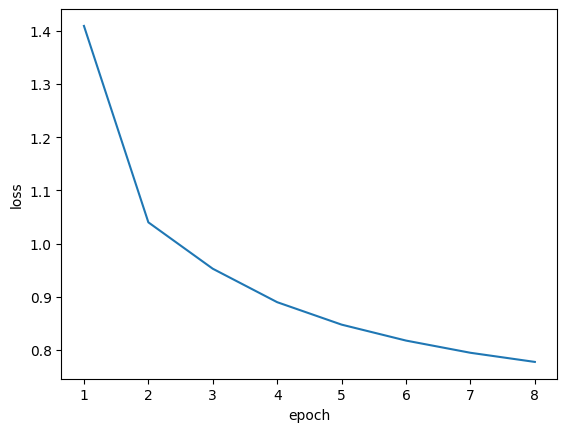

In [23]:
losses = []
num_epochs = 8

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    with tqdm.tqdm(total=len(dataloader)) as prbar:
        for i, batch in enumerate(dataloader):
            loss = training_step(model, batch, tokenizer.vocab_size, criterion, optimizer, device)
            epoch_loss += loss
        
            if i % 100 == 0:
                #print(f'Done {i/len(dataloader) * 100:.2f}%, Loss: {loss:.4f}')
                metrics_str = f"Loss: {round(loss, 4)} "
                #for k, v in metrics_dict.items():
                #    metrics_str += f"{k}: {round(float(v), 4)} "
                prbar.set_description(metrics_str)
                prbar.update(100)
    
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    torch.save(model.state_dict(), "rnn.pt")

In [27]:
[model.inference("Пилите, Шура, пилите. Они ", device=device) for _ in range(10)]


['<bos>Пилите, Шура, пилите. Они развледи као-нибудь за ило у меня семекое-со голова, на ест?! Вешила звоние, ты начинаюсь, сторацовар ретьше за фyшпумеда капитанило помою. Один современной Лепать славиреончика. Поздно, вам!<eos>',
 '<bos>Пилите, Шура, пилите. Они я это жестотибрялся, коляюм, ног, у ее смыд достуз.<eos>',
 '<bos>Пилите, Шура, пилите. Они начали даже госуковых солетвора.<eos>',
 '<bos>Пилите, Шура, пилите. Они Лодиваться да вдумают поител приходится, слезы на Аутарине 45Шеiм...<eos>',
 '<bos>Пилите, Шура, пилите. Они ялут спятся включить н заеду!..<eos>',
 '<bos>Пилите, Шура, пилите. Они знает, она наркоешисто Ной гриджим.<eos>',
 '<bos>Пилите, Шура, пилите. Они с он, станик.<eos>',
 '<bos>Пилите, Шура, пилите. Они жесторожную тамув. Только у вас х, кое троние белом...<eos>',
 '<bos>Пилите, Шура, пилите. Они прувска - Помощаюсь, а с теучатой ар знать сфаума, настоящий мамайской снега, воин помостоние маесло вы адметного видев?<eos>',
 '<bos>Пилите, Шура, пилите. Они с в

In [25]:
# Дополнительная секция

Теперь попробуем написать свой собственный RNN. Это будет довольно простая модель с одним слоем.


In [28]:
# YOUR CODE: custom model nn.Module, changed CharRNN, etc

class CustomCharRNN(nn.Module):
    def __init__(
        self,
        tokenizer,
        hidden_dim: int = 256,
        num_layers: int = 1,
        drop_prob: float = 0.5,
        max_len: int = 512,
    ) -> None:
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.max_len = max_len
        # create mappings
        self.tokenizer = tokenizer

        ## define the LSTM, dropout and fully connected layers
        self.encoder = nn.Embedding(self.tokenizer.vocab_size, self.hidden_dim)
        self.rnn = nn.RNN(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            num_layers=self.num_layers,
            batch_first=True,
        )
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.decoder = nn.Linear(
            in_features=self.hidden_dim,
            out_features=self.tokenizer.vocab_size,
        )

    # Forward - это проход вперёд по слою
    def forward(
        self, x: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # one-hot encode your sequence
        packed_embeds = self.encoder(x) # pack your sequence. This helps with the efficiency. Use torch function pack_padded_sequence
        outputs, hidden = self.rnn(packed_embeds) # run you model
        
        # TODO: Понять нафига
        #  out, lengths = # pad sequence back
        
        # Pass through a dropout layer and fully connected layer
        out = self.dropout(outputs)
        ## Get the output for classification.
        out = self.decoder(out)

        return out, hidden

    
    # инференс - режим не обучения (По сути штатная работа)
    def inference(self, prefix='<bos> ', device="cpu"):
        tokens = torch.tensor([self.tokenizer.encode(prefix, eos=False)], device=device) # encode prefix
        
        # 2 stopping conditions: reaching max len or getting <eos> token
        # Generate sequence iteratively
        for _ in range(self.max_len - len(tokens[0])):
            # YOUR CODE: generate sequence one by one
            # Pass tokens through the embedding layer
            logits, hidden = self.forward(tokens, torch.tensor([tokens.size(1)]))
            
            # Get the last token's logits and sample a token
            next_token_logits = logits[:, -1, :]
            new_token = torch.multinomial(
                torch.nn.functional.softmax(next_token_logits, dim=-1), num_samples=1
            )

            # Append the new token
            tokens = torch.cat([tokens, new_token], dim=1)

            # Stop if the <eos> token is generated
            if new_token.item() == self.tokenizer.encode_symbol("<eos>"):
                break
        # Decode the token IDs back into a string
        return self.tokenizer.decode(tokens.squeeze().tolist())


In [29]:
real_rnn = CustomCharRNN(tokenizer, hidden_dim=n_hidden, num_layers=1, drop_prob=drop_prob).to(device)
hidden = None
optimizer2 = torch.optim.Adam(real_rnn.parameters(), lr=1e-3)

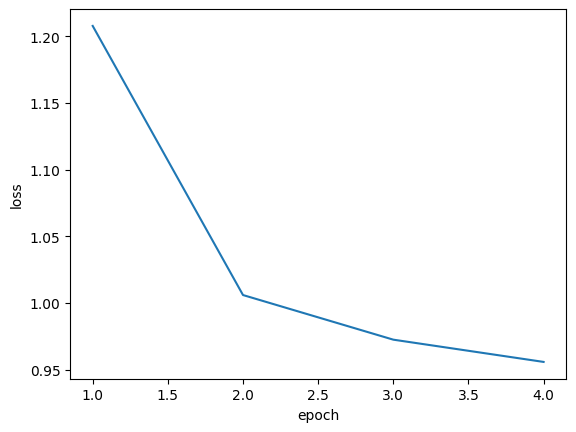

Loss: 0.9575 :  64%|██████▍   | 800/1242 [00:41<00:25, 17.62it/s]

In [ ]:
losses = []
num_epochs = 8

for epoch in range(1, num_epochs + 1):
    epoch_loss = 0
    with tqdm.tqdm(total=len(dataloader)) as prbar:
        for i, batch in enumerate(dataloader):
            loss = training_step(real_rnn, batch, tokenizer.vocab_size, criterion, optimizer2, device)
            epoch_loss += loss
        
            if i % 100 == 0:
                metrics_str = f"Loss: {round(loss, 4)} "
                prbar.set_description(metrics_str)
                prbar.update(100)
    
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    plot_losses(losses)
    torch.save(real_rnn.state_dict(), "real_rnn.pt")

In [ ]:
[model.inference("Пилите, Шура, пилите. Они ", device=device) for _ in range(10)]
